In [6]:
import numpy as np
import pycolmap
import torch
import torch.nn as nn

from splat.gaussians import Gaussians
from splat.utils import read_images_binary, read_images_text

stem = "/Users/derek/Desktop/intro_to_gaussian_splatting"
# stem = "/home/da2986/intro_to_gaussian_splatting"


colmap_path = f"{stem}/data/treehill/sparse/0"
reconstruction = pycolmap.Reconstruction(colmap_path)

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []


for idx, point in enumerate(points3d.values()):
    if point.track.length() >= 2:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color)

gaussians = Gaussians(
    torch.Tensor(all_points3d),
    torch.Tensor(all_point_colors),
    model_path=f"{stem}/data/point_clouds",
)

In [7]:
from splat.image import GaussianImage
from splat.utils import (
    build_rotation,
    get_extrinsic_matrix,
    getIntinsicMatrix,
    read_camera_file,
    read_image_file,
)

camera_dict = read_camera_file(colmap_path)
image_dict = read_image_file(colmap_path)
images = {}
for idx in image_dict.keys():
    image = image_dict[idx]
    camera = camera_dict[image.camera_id]
    image = GaussianImage(camera=camera, image=image)
    images[idx] = image


image_num = 100
rotation_matrix = build_rotation(torch.Tensor(image_dict[image_num].qvec).unsqueeze(0))
translation = torch.Tensor(image_dict[image_num].tvec).unsqueeze(0)
extrinsic_matrix = get_extrinsic_matrix(rotation_matrix, translation).T
focal_x, focal_y = camera_dict[image_dict[image_num].camera_id].params[:2]
c_x, c_y = camera_dict[image_dict[image_num].camera_id].params[2:4]
width = camera_dict[image_dict[image_num].camera_id].width
wdith = 1000
height = camera_dict[image_dict[image_num].camera_id].height
height = 750
intrinsic_matrix = getIntinsicMatrix(focal_x, focal_y, height, width).T

In [8]:
from splat.render_engine.gaussianScene2 import GaussianScene2

scene = GaussianScene2(gaussians=gaussians)
scene.device = "cpu"
TILE_SIZE = 16

In [9]:
processed_gaussians = scene.preprocess(
    extrinsic_matrix=extrinsic_matrix,
    intrinsic_matrix=intrinsic_matrix,
    focal_x=focal_x,
    focal_y=focal_y,
    width=width,
    height=height,
    
    tile_size=TILE_SIZE
)

torch.Size([2, 5682]) torch.Size([2, 5682])


In [6]:
height = 3400
width = 5100
with torch.no_grad():
    output_image = scene.render(
        preprocessed_gaussians=processed_gaussians, height=height, width=width, tile_size=TILE_SIZE
    )

starting sum
ending sum


100%|██████████| 35168/35168 [00:00<00:00, 93282.62it/s]


156 31


 66%|██████▋   | 23376/35168 [00:00<00:00, 67464.04it/s]

x_value: 2500, y_value: 500, gaussian_strength: 0.0017302853520959616, alpha: tensor([0.0017]), test_t: tensor([0.9983]), mean_2d: tensor([2513.1323,  512.9888])
x_value: 2500, y_value: 500, gaussian_strength: 0.0027158588636666536, alpha: tensor([0.0027]), test_t: tensor([0.9956]), mean_2d: tensor([2492.6787,  516.1900])
x_value: 2500, y_value: 500, gaussian_strength: 9.859375859377906e-05, alpha: tensor([9.8584e-05]), test_t: tensor([0.9955]), mean_2d: tensor([2512.4011,  524.4392])
x_value: 2500, y_value: 500, gaussian_strength: 1.159387963411973e-07, alpha: tensor([1.1593e-07]), test_t: tensor([0.9955]), mean_2d: tensor([2529.3064,  521.1459])


100%|██████████| 35168/35168 [00:00<00:00, 70714.60it/s]


In [7]:
output_image[500, 2500]

tensor([0.0010, 0.0008, 0.0006])

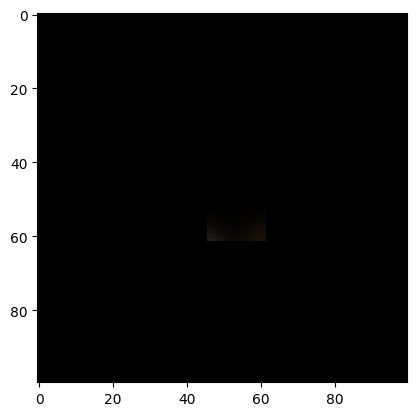

In [8]:
import matplotlib.pyplot as plt

plt.imshow(output_image[450: 550, 2450: 2550].cpu().detach())
plt.show()